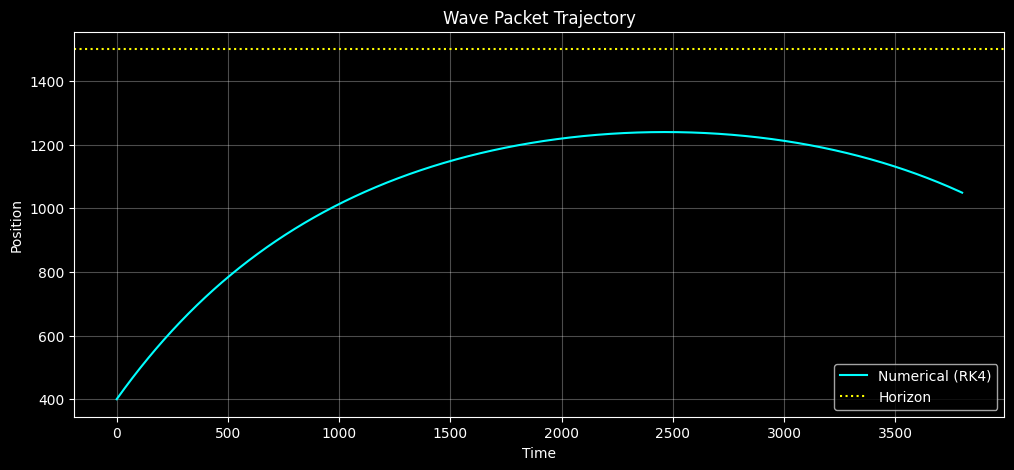

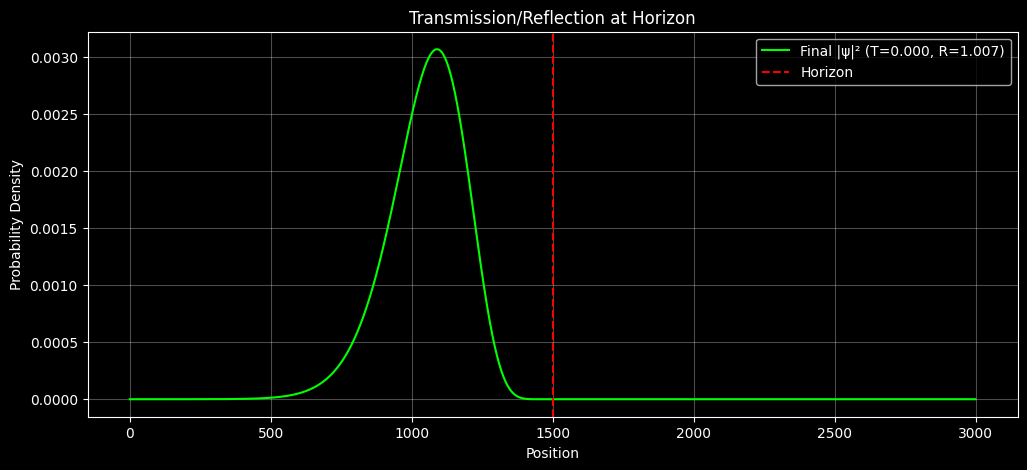

Transmission coefficient (T): 0.0000
Reflection coefficient (R): 1.0071
Horizon position: 1500.26


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import airy
plt.style.use('dark_background')

# ===== Numerical Simulation Parameters =====
L = 3000
x0 = 400  # Initial packet position
k0 = 0.2  # Initial momentum
dt = 0.1
sigma = 20  # Wave packet width
frames = 38000
x = np.arange(L)
dx = 1
a = 2003  # Transition width
t_max = 2  # Max tilt

# Horizon position
x_horizon = x0 + a * np.arctanh(1 / t_max)

# Initial wavefunction (scalar)
psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x - x0))
psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))  # Normalize

# Storage for results
x_c_list = []  # Wave packet center (numerical)
time_list = []

# ===== Main Simulation Loop (RK4) =====
for frame in range(frames):
    current_time = frame * dt
    
    # Track wave packet center (total probability density)
    total_density = np.abs(psi)**2
    x_c = np.sum(x * total_density) / np.sum(total_density)
    x_c_list.append(x_c)
    time_list.append(current_time)
    
    # Tilt profile
    t = t_max * np.tanh((x - x0) / a)
    alpha = 1 - t
    
    # RK4 integration (scalar)
    # Stage 1: Compute k1
    dpsi_dx = np.zeros(L, dtype=complex)
    dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx)
    dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)      # Periodic BC
    dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  
    k1 = -alpha * dpsi_dx

    # Stage 2: Compute k2
    psi_temp = psi + 0.5 * dt * k1
    dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
    dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
    dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
    k2 = -alpha * dpsi_dx

    # Stage 3: Compute k3
    psi_temp = psi + 0.5 * dt * k2
    dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
    dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
    dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
    k3 = -alpha * dpsi_dx

    # Stage 4: Compute k4
    psi_temp = psi + dt * k3
    dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
    dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
    dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
    k4 = -alpha * dpsi_dx

    # RK4 Update
    psi = psi + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    # Normalize occasionally
    if frame % 100 == 0:
        psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))

# ===== Analysis =====
final_density = np.abs(psi)**2
transmission_region = x > x_horizon
reflection_region = x < x_horizon
T = np.sum(final_density[transmission_region]) * dx
R = np.sum(final_density[reflection_region]) * dx

# Airy function near horizon (for reference)
dt_dx_horizon = (t_max / a) * (1 - (1/t_max)**2)
ell = (2 * abs(dt_dx_horizon))**(-1/3)
x_airy = np.linspace(x_horizon - 50, x_horizon + 50, 200)
xi = (x_airy - x_horizon) / ell
Ai, _, _, _ = airy(xi)

# ===== Plots =====
# Plot 1: Trajectory
plt.figure(figsize=(12, 5))
plt.plot(time_list, x_c_list, 'cyan', label="Numerical (RK4)")
plt.axhline(y=x_horizon, color='yellow', linestyle=':', label="Horizon")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Wave Packet Trajectory")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot 2: Final density
plt.figure(figsize=(12, 5))
plt.plot(x, final_density, 'lime', label=f"Final |ψ|² (T={T:.3f}, R={R:.3f})")
plt.axvline(x=x_horizon, color='red', linestyle='--', label="Horizon")
plt.xlabel("Position")
plt.ylabel("Probability Density")
plt.title("Transmission/Reflection at Horizon")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Transmission coefficient (T): {T:.4f}")
print(f"Reflection coefficient (R): {R:.4f}")
print(f"Horizon position: {x_horizon:.2f}")